SEMANTIC CHUNKING STEP BY STEP

In [24]:
from read_docx import read_docx
file_path = 'data/Raptor Contract.docx'
file = read_docx(file_path)
file

"\nSTOCK PURCHASE AGREEMENT\nBY AND AMONG\n[BUYER],\n[TARGET COMPANY],\nTHE SELLERS LISTED ON SCHEDULE I HERETO\nAND\nTHE SELLERS’ REPRESENTATIVE NAMED HEREIN\nDated as of [●]\n\n[This document is intended solely to facilitate discussions among the parties identified herein.  Neither this document nor such discussions are intended to create, nor will either or both be deemed to create, a legally binding or enforceable offer or agreement of any type or nature, unless and until a definitive written agreement is executed and delivered by each of the parties hereto.\n\nThis document shall be kept confidential pursuant to the terms of the Confidentiality Agreement entered into by the parties and, if applicable, its affiliates with respect to the subject matter hereof.]\n\n\nTABLE OF CONTENTS\nARTICLE I DEFINITIONS; CERTAIN RULES OF CONSTRUCTION\t2\nSection 1.01\tDefinitions\t2\nSection 1.02\tCertain Matters of Construction\t13\nARTICLE II PURCHASE AND SALE OF SHARES AND WARRANTS; TREATMENT 

In [1]:
#READING THE DOCUMENT
with open('file.txt') as file:
    essay = file.read()

In [2]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} senteneces were found")

19 senteneces were found


In [3]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]

In [5]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [2]:
sentences 

NameError: name 'combine_sentences' is not defined

In [18]:
from langchain_openai.embeddings import OpenAIEmbeddings
from dotenv import load_dotenv
import os
load_dotenv
oaiembeds = OpenAIEmbeddings()

In [21]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

In [27]:
#assigning embeddings to each sentence based on the index
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]


Semantic Chunking Based on consecutive sentences embeddings

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [29]:
distances, sentences = calculate_cosine_distances(sentences)

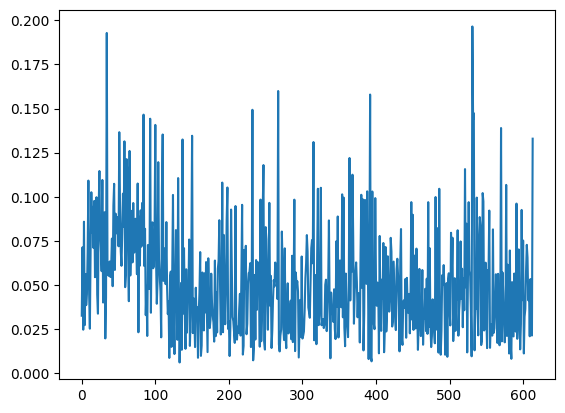

In [31]:
import matplotlib.pyplot as plt

plt.plot(distances);

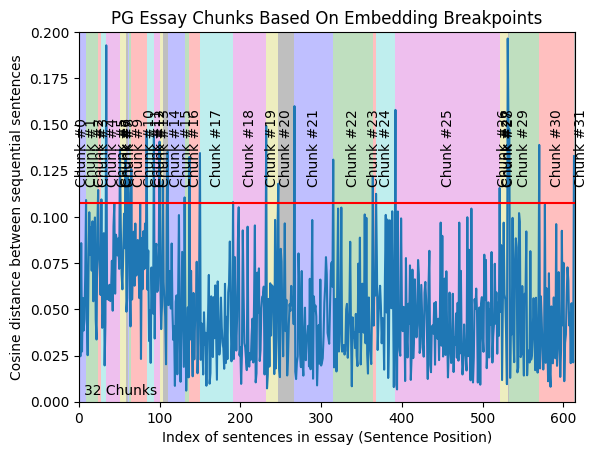

In [33]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [11]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

NameError: name 'indices_above_thresh' is not defined

Vectorstore locally the indexes of chunks using faiss-gpu

In [35]:
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
vectorstore = FAISS.from_texts(
    chunks, embedding=OpenAIEmbeddings()
)


In [36]:
vectorstore.save_local("index_Raptor_Contract")

#LOAD FROM LOCAL '/fiass_index'

In [1]:

# Load the local FAISS index
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
vectorstore_local = FAISS.load_local("index_Raptor_Contract", OpenAIEmbeddings())
retriever = vectorstore_local.as_retriever(search_kwargs={"k" : 20}) # Specifying the value of "k" 

In [6]:
def get_chunks_from_vectorstore(vectorstore):
    chunks = []
    vectors = vectorstore.get_all_vectors(())
    for vector in vectors:
        chunks.append(vector.metadata['page_content'])
    return chunks

In [7]:

chunks = get_chunks_from_vectorstore(vectorstore_local)

AttributeError: 'FAISS' object has no attribute 'get_all_vectors'

In [4]:
for doc in relevant_docs:
  print(doc.page_content)
  print('\n')

SURVIVAL; RECOURSE LIMITATIONS
Survival
. The representations and warranties of the parties contained in this Agreement shall terminate automatically as of the Closing, and no Party or any of its Affiliates or its or their respective Representatives will have any recourse against the other party or any of its Affiliates or its or their respective Representatives with respect to such representations, warranties, covenants and agreements. The covenants and agreements contained in this Agreement that are to be performed after the Closing will survive the Closing in accordance with their terms. Notwithstanding anything in this Agreement (including in this ‎Section 10.01 or ‎Section 10.02) or otherwise to the contrary, nothing will limit or reduce Buyer’s ability to make claims or recover or receive any remedy from any Person with respect to claims arising from fraud committed by such Person. Recourse Limitations. Other than claims arising from fraud committed by the Person, no director, of

Chunking semantically from absolute location of each embeddings

Semantic Chunking Comparing each sentence with every other sentences embedding

for the followning reason

1. to capture longer dependencies with in the document
2. legal contract document's mostly contain references with in the text so chunking 
    them semantically based on only the consecutive element case will make the less 
    efficient in storing semantically closer chunks closer it will be relative 
    so to make embedding compared with absolute location 

    so we will have {n*(n-1)/2} number of distances for the embedding

In [7]:
from langchain_openai.embeddings import OpenAIEmbeddings
from dotenv import load_dotenv
import os
load_dotenv
oaiembeds = OpenAIEmbeddings()

In [8]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

In [9]:
#assigning embeddings to each sentence based on the index
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences)):
        embedding_current = sentences[i]['combined_sentence_embedding']
        
        for j in range(i + 1, len(sentences)):
            embedding_next = sentences[j]['combined_sentence_embedding']
            
            # Calculate cosine similarity
            similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
            
            # Convert to cosine distance
            distance = 1 - similarity

            # Append cosine distance to the list
            distances.append(distance)

            # Store distance in the dictionary
            sentences[i]['distance_to_' + str(j)] = distance
            sentences[j]['distance_to_' + str(i)] = distance  # Optionally, you can store distances in both directions

    return distances, sentences

# Assuming sentences is properly defined with embeddings



In [11]:
distances, sentences = calculate_cosine_distances(sentences)

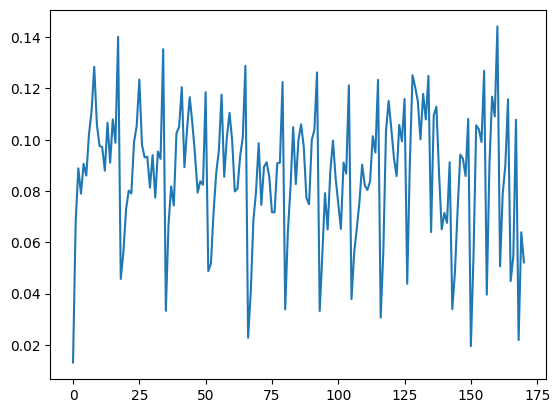

In [12]:
import matplotlib.pyplot as plt

plt.plot(distances);

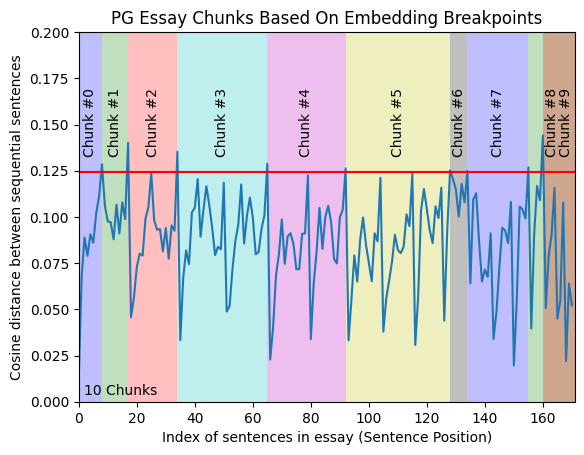

In [13]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
vectorstore = FAISS.from_texts(
    chunks, embedding=OpenAIEmbeddings()
)


In [ ]:
#UNEXECUTED TO SAVE LOCAL(FAISS-INDEX)

vectorstore.save_local("PLACE_HOLDER")


Context Reordering to minimizer "Lost in the Middle" the most important context might be 
in the biggening or last.

In [8]:
retriever = vectorstore_local.as_retriever(search_kwargs={"k" : 5}) # Specifying the value of "k" 
relevant_docs = retriever.get_relevant_documents("Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties")
relevant_docs


[Document(page_content='SURVIVAL; RECOURSE LIMITATIONS\nSurvival\n. The representations and warranties of the parties contained in this Agreement shall terminate automatically as of the Closing, and no Party or any of its Affiliates or its or their respective Representatives will have any recourse against the other party or any of its Affiliates or its or their respective Representatives with respect to such representations, warranties, covenants and agreements. The covenants and agreements contained in this Agreement that are to be performed after the Closing will survive the Closing in accordance with their terms. Notwithstanding anything in this Agreement (including in this \u200eSection 10.01 or \u200eSection 10.02) or otherwise to the contrary, nothing will limit or reduce Buyer’s ability to make claims or recover or receive any remedy from any Person with respect to claims arising from fraud committed by such Person. Recourse Limitations. Other than claims arising from fraud comm

In [6]:
# Vectorstore alone retrieves the small chunks
retriever.vectorstore.similarity_search("law")[0]

Document(page_content='“Legal Requirement” means any federal, state or local or any foreign law (including Israeli law), statute, legislation, case law, ordinance, order, extension orders, code, rule, regulation, or promulgation, or any Government Order, or any Permit granted under any of the foregoing, or any similar provision having the force or effect of law.')

In [ ]:
# Reorder the documents:
# Less relevant document will be at the middle of the list and more
# relevant elements at beginning / end.
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(relevant_docs)

# Confirm that the 4 relevant documents are at beginning and end.
reordered_docs

ActiveLoop Deep Memory for recall(accuracy), cost, and latency

In [7]:
import getpass
import os

from langchain.chains import RetrievalQA
from langchain.vectorstores.deeplake import DeepLake
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
import os
load_dotenv
token = os.getenv("ACTIVELOOP_TOKEN")
openai_embeddings = OpenAIEmbeddings()
ORG_ID = "lenjisa48"

In [9]:
db = DeepLake(
    dataset_path=f"hub://{ORG_ID}/Contract-clause-RAG",  # org_id stands for your username or organization from activeloop
    embedding=openai_embeddings,
    runtime={"tensor_db": True},
    token=token,
    # overwrite=True, # user overwrite flag if you want to overwrite the full dataset
    read_only=False,
)

Your Deep Lake dataset has been successfully created!


In [ ]:
docs_new.extend(docs)

Prompttemplate and Memory

In [17]:
from langchain_core.prompts import ChatPromptTemplate
template = """<human>: As a legal contract advisor, your role is pivotal in navigating the complexities of the contract clause agreement. Your responsibility extends beyond mere interpretation; it encompasses a meticulous analysis and strategic elucidation of the user's query based on the given {context}. To accomplish this effectively, consider the following steps:

1. Contextual Understanding: Begin by immersing yourself in the provided contract clause or {context}, grasping the intricacies of the terms, conditions, and potential implications involved. Pay particular attention to any ambiguous language or clauses that may pose risks to your client.

2. User Query Analysis: Carefully dissect the user's question within the {context} or the contract clause. Identify any specific clauses or provisions that the question pertains to and analyze their impact on your client's interests or question.

3. Comprehensive Response: Craft a response that addresses the user's query comprehensively, taking into account the nuances of the contract clause. Provide detailed explanations and recommendations, ensuring that your client is fully informed of their rights and obligations under the agreement.

4. Risk Mitigation: As you formulate your response, prioritize the mitigation of risks inherent in the contract clause. Identify potential pitfalls or areas of concern and propose proactive measures to safeguard your client's interests and minimize their exposure to liability.

5. Strategic Communication: Ensure that your response is conveyed in a clear, concise, and persuasive manner. Articulate your points effectively, citing relevant legal precedents, industry standards, and best practices to support your arguments and strengthen your client's position.

By following these steps diligently, you can provide informed, strategic guidance that empowers your client and ensures the integrity of the contract clause agreement.

NB: If the provided {context} is not sufficient enough to answer the user question please avoid any assumption.
Question: {question}

\n

<bot>:
"""

ANSWER_PROMPT = ChatPromptTemplate.from_template(template)


In [18]:
from langchain.prompts.prompt import PromptTemplate

_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In [19]:
from langchain.schema import format_document
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langchain_core.runnables import RunnableParallel
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain.schema import StrOutputParser

In [20]:
DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")


def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

In [21]:
_inputs = RunnableParallel(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: get_buffer_string(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(temperature=0)
    | StrOutputParser(),
)
_context = {
    "context": itemgetter("standalone_question") | retriever | _combine_documents,
    "question": lambda x: x["standalone_question"],
}
conversational_qa_chain = _inputs | _context | ANSWER_PROMPT | ChatOpenAI()

In [25]:
class AIMessage:
    def __init__(self, content):
        self.content = content

# Example instance
example_message = conversational_qa_chain.invoke(
    {
        "question": "what is the contract about?",
        "chat_history": [],
    }
)
# Function to print content with line breaks
def print_with_line_breaks(message, max_line_length=80):
    words = message.split()
    lines = []
    current_line = ''
    for word in words:
        if len(current_line) + len(word) + 1 <= max_line_length:
            current_line += word + ' '
        else:
            lines.append(current_line)
            current_line = word + ' '
    if current_line:
        lines.append(current_line)
    for line in lines:
        print(line)

# Print the content with line breaks
print("Message content:")
print_with_line_breaks(example_message.content)


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 38227 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

MultiVector Retriever

Agentic chunking chunking with the help of LLM

In [3]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub

In [4]:
obj = hub.pull("wfh/proposal-indexing")
llm = ChatOpenAI()

/home/w/Contract-Advisor-RAG-Towards-Building-A-High-Precision-Legal-Expert-LLM-APP-1/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [5]:
# use it in a runnable
runnable = obj | llm

In [6]:
# Pydantic data class
class Sentences(BaseModel):
    sentences: List[str]
    
# Extraction
extraction_chain = create_extraction_chain_pydantic(pydantic_schema=Sentences, llm=llm)

In [7]:
def get_propositions(text):
    runnable_output = runnable.invoke({
    	"input": text
    }).content
    
    propositions = extraction_chain.run(runnable_output)[0].sentences
    return propositions

In [10]:
paragraphs = essay.split(r'(?<=[.?!])\s+')

In [11]:
len(paragraphs)

1

In [12]:
essay_propositions = []

for i, para in enumerate(paragraphs[:5]):
    propositions = get_propositions(para)
    
    essay_propositions.extend(propositions)
    print (f"Done with {i}")

/home/w/Contract-Advisor-RAG-Towards-Building-A-High-Precision-Legal-Expert-LLM-APP-1/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Done with 0


In [13]:
print (f"You have {len(essay_propositions)} propositions")
essay_propositions[:10]

You have 11 propositions


['My name is Daniel Zerihun.',
 'I was born in Ethiopia.',
 'Nazreth is the town where I was born.',
 'Nazreth is located in the east relative to the capital Addis Ababa.',
 'I am an electrical engineering graduate.',
 'Currently, I am working on data science and AI projects.',
 'I have worked on many substantial projects.',
 'I may have deeper knowledge regarding NLP and Large language model.',
 'Currently, I am developing an end-to-end RAG system for a tech firm called LissyAI.',
 'LissyAI focuses on providing AI-driven solutions to automate legal contract tasks.']

In [15]:
# mini script I made
from agentic_chunker import AgenticChunker

In [16]:
ac = AgenticChunker()

In [17]:
ac.add_propositions(essay_propositions)



Adding: 'My name is Daniel Zerihun.'
No chunks, creating a new one
Created new chunk (3fc6a): Introductions & Names

Adding: 'I was born in Ethiopia.'
No chunks found
Created new chunk (fb754): Nationality & Origin

Adding: 'Nazreth is the town where I was born.'
Chunk Found (fb754), adding to: Nationality & Origin

Adding: 'Nazreth is located in the east relative to the capital Addis Ababa.'
No chunks found
Created new chunk (820e5): Ethiopian Cities' Geography

Adding: 'I am an electrical engineering graduate.'
No chunks found
Created new chunk (2e26e): Education & Qualifications

Adding: 'Currently, I am working on data science and AI projects.'
No chunks found
Created new chunk (80d3b): Current Projects

Adding: 'I have worked on many substantial projects.'
Chunk Found (80d3b), adding to: Current Projects

Adding: 'I may have deeper knowledge regarding NLP and Large language model.'
Chunk Found (80d3b), adding to: Data Science & AI Experience & Projects

Adding: 'Currently, I am d

In [18]:
ac.pretty_print_chunks()


You have 6 chunks

Chunk #0
Chunk ID: 3fc6a
Summary: This chunk contains information about individuals introducing themselves and stating their names.
Propositions:
    -My name is Daniel Zerihun.



Chunk #1
Chunk ID: fb754
Summary: This chunk contains information about individuals' specific hometowns and countries of origin.
Propositions:
    -I was born in Ethiopia.
    -Nazreth is the town where I was born.



Chunk #2
Chunk ID: 820e5
Summary: This chunk contains information about the geographical locations of cities in Ethiopia.
Propositions:
    -Nazreth is located in the east relative to the capital Addis Ababa.



Chunk #3
Chunk ID: 2e26e
Summary: This chunk contains information about individuals' educational backgrounds and qualifications.
Propositions:
    -I am an electrical engineering graduate.



Chunk #4
Chunk ID: 80d3b
Summary: This chunk details an individual's professional background, projects, and expertise in data science, AI, with a focus on NLP and large language

In [19]:
chunks = ac.get_chunks(get_type='list_of_strings')

Store LLM based chuck indexes locally

In [20]:
len(chunks)

6

In [21]:
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
vectorstore = FAISS.from_texts(
    chunks, embedding=OpenAIEmbeddings()
)


In [22]:
vectorstore.save_local("fiass_index_llm_chunks")

Load embedded indexes from local

In [35]:

# Load the local FAISS index
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
vectorstore_local = FAISS.load_local("fiass_index", OpenAIEmbeddings())
retriever = vectorstore_local.as_retriever(search_kwargs={"k" : 5}) # Specifying the value of "k" 

In [15]:
relevant_docs = retriever.get_relevant_documents("Generation")
relevant_docs

[Document(page_content='my name is daniel zerihun, i was born is ethiopia and town named Nazreth which\nlocated in the eastern relative to the capital Addis Ababa. i am electrical \nengineering graduate currently i am into data science and ai staff, and made a \nlot of substantial projects i have may be deeper knowledge regarding NLP and \nLarge language model.'),
 Document(page_content='currently i am working of developing end - to - end \nRAG system for tech firm call lissyAI which focuses on providing ai driven \nsolution to automate the legal contract lawye, which will replacec the task of \nconsultant lawyer')]

Deepinfra

In [3]:
from dotenv import load_dotenv
import os
from langchain_community.embeddings import DeepInfraEmbeddings

In [4]:
embeddings = DeepInfraEmbeddings(
    model_id="sentence-transformers/clip-ViT-B-32",
    query_instruction="",
    embed_instruction="",
)

In [5]:
docs = ["Dog is not a cat", "Beta is the second letter of Greek alphabet"]
document_result = embeddings.embed_documents(docs)

ValueError: Error raised by inference API HTTP code: 401, {"detail":"User is not authorized to access this resource"}

Deserialization of pkl file from local faiss store

In [21]:
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings

pkl = vectorstore_local.serialize_to_bytes() 
db = FAISS.deserialize_from_bytes(
    embeddings=OpenAIEmbeddings(), serialized=pkl
)  # Load the index


In [30]:
ids = db.get_doc_ids()

AttributeError: 'FAISS' object has no attribute 'get_doc_ids'